# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных


Данные геологоразведки трёх регионов находятся в файлах: 
- `/datasets/geo_data_0.csv.`
- `/datasets/geo_data_1.csv.`
- `/datasets/geo_data_2.csv.`

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек;
- **product** — объём запасов в скважине (тыс. баррелей).


***Условия задачи:***
- Для обучения модели подходит только линейная регрессия.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
# Импортируем базы данных, которые пригодятся в нашем исследование
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from copy import deepcopy
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from numpy.random import RandomState

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

**CSV-файлы с данными**

 - Данные по первому региону — geo_data_0.csv
 - по второму региону — geo_data_1.csv
 - по третьему — geo_data_2.csv

In [2]:
# Прочитаем файлы и сохраним в датафреймы
first_data = pd.read_csv('/datasets/geo_data_0.csv')
second_data = pd.read_csv('/datasets/geo_data_1.csv')
third_data = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Сделаем функцию для знакомства с данными геологоразведки
def information(data):

# Посмотрим основную информацию датафрейма
    display(data.info(), data.describe(include='all').T.round(2), data.head())

# Посмотрим кол-во дубликатов
    print('Кол-во дубликатов', data.duplicated().sum())

# Проверим кол-во пропусков в столбцах датафрейма
    print('Кол-во пропусков в столбцах', '\n', data.isna().sum())
    
# Построим общую гистограмму для всех столбцов таблицы
    data.hist(figsize=(10, 6))
    plt.show()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,A5aEY,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331
f1,100000.0,NaN,NaN,NaN,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,NaN,NaN,NaN,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379
product,100000.0,NaN,NaN,NaN,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Кол-во дубликатов 0
Кол-во пропусков в столбцах 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


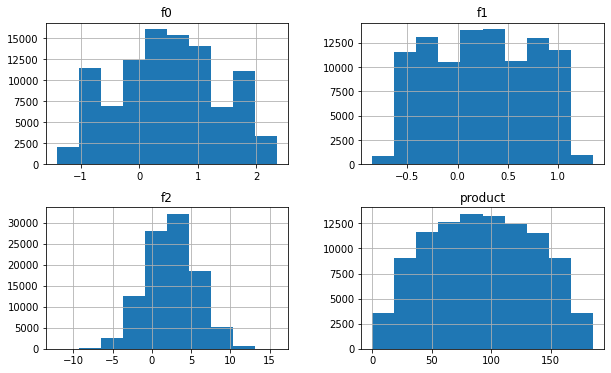

In [5]:
# Информация по первому региону
information(first_data)

В датафрейме по первому региону сто тысяч строк. Столбцы названы в нижнем регистре. Пропуски в столбцах отсутсвуют, явных дубликатов нет. Формат столбцов - десятичный (числа с плавающей точкой), кроме 'id' - строковый тип, т.к. уникальный индификатор скважины. При этом есть дублирование уникального индификатора - посмотрим подробнее.

Относительно распределения:
- первый признак точки (f0) - значение среднего и медианы приблизительно равны. Большая часть признаков распределена от -1 до -0,7; от -0,2 до 1,1 и от 1,6 до 2.
- второй признак точки (f1) - значение среднего и медианы так же приблизительно равны. Распределение относительно первой точки более равномерное, есть небольшие просадки в диапазоне от -0,25 до 0 и от 0,49 до 0,7.
- третий признак точки (f2) - так же значение среднего и медианы приблизительно равны. Распределение нормальное. Пик приходится на значения от 2,5 до 4,9. Значения меньше -9 и больше 13 похожи на выбросы.
- объём запасов в скважине - Нормальное распределение. Основная часть объема запаса находится в диапазоне от 20 тыс. баррелей до 165 тыс. баррелей.

In [6]:
# Посмотрим детальнее на дублированные уникальыне индификаторы
first_data[first_data.duplicated(['id'], keep=False)].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Так как данные столбцов f0, f1, f2 и product не повторяются для дублированных значений id, то "задвоенные" строки мы удалять не будем, потмоу что не знаем ошибочные это данные или с корректной информацией. Будем использовать в обучение модели.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,wt4Uk,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,NaN,NaN,NaN,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,NaN,NaN,NaN,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,NaN,NaN,NaN,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Кол-во дубликатов 0
Кол-во пропусков в столбцах 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


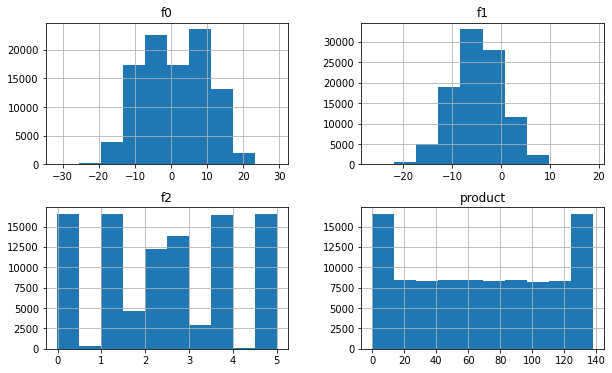

In [7]:
# Информация по второму региону
information(second_data)

Как и в первом датафрейме во втором регионе сто тысяч строк. Основная информация аналогичная: название столбцов такое же, пропуски отсутсвуют, явных дубликатов нет, формат столбцов такой же. Присутсвует дублирование уникального индификатора.

Относительно распределения:
- первый признак точки (f0) - значение среднего и медианы приблизительно равны, различие в одну сотую. Большая часть признаков распределена от -12 до 18; Два пика: от -6 до -1 и в диапазоне от 6 до 10. Значения меньше -26 и больше 22 похожи на выбросы.
- второй признак точки (f1) - значение среднего и медианы так же приблизительно равны. Распределение нормальное. Максимальная часть признаков приходится на значения от -9 до -5. Основная часть распределена от -12 до 5. Значения меньше -21 и больше 10 похожи на выбросы.
- третий признак точки (f2) - значение среднего и медианы различаются ~ 0,5. Распределение равномерное между значениями 0-0.5, 1-1.5, 3.5-4, 4.5-5. Значения в отрезке от 2 до 3 чуть просидает по кол-ву признаков, но он более плотный.
- объём запасов в скважине - Сильное различик медианного и среднего значений. Диапазон от 16 тыс. баррелей до 124 тыс. баррелей распределен равномерно. Пики значений приходтся на запасы до 16 тыс. баррелей и от 124 тыс. до 138 тыс. баррелей.

In [8]:
# Посмотрим детальнее на дублированные уникальыне индификаторы
second_data[second_data.duplicated(['id'], keep=False)].sort_values('id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Аналогичная ситуация как в первом регионе. Данные оставляем.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,xCHr8,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,NaN,NaN,NaN,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801
f2,100000.0,NaN,NaN,NaN,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,NaN,NaN,NaN,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Кол-во дубликатов 0
Кол-во пропусков в столбцах 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


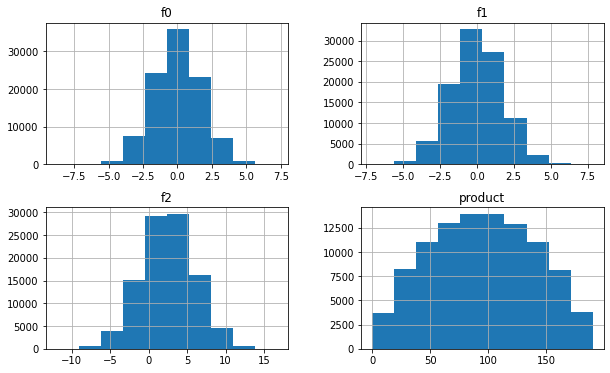

In [9]:
# Информация по третьему региону
information(third_data)

Как и в предыдущих датафреймах: сто тысяч строк, основная информация аналогичная. Присутсвует дублирование уникального индификатора.

По графику распределения:
- Каждое распределение нормальное. Значение среднего и медианы весьма близки.
- первый признак точки (f0) - Основаня часть признаков распределена от -2,5 до 2,5. Пик от -0,5 до 0,5. Значения меньше -5,5 и больше 5,5 похожи на выбросы.
- второй признак точки (f1) - График и значения похожи на распределение f0. Основаня часть признаков распределена от -2,5 до 2,7. Пик от -1 до 0. Значения меньше -5,5 и больше 5,5 похожи на выбросы.
- третий признак точки (f2) - Основаня часть признаков распределена от -4 до 7. Пик от 0 до 5. Значения меньше -9 и больше 14 похожи на выбросы.
- объём запасов в скважине - Симметричное распределение с пиком в 95 тыс. баррелей.

In [10]:
# Посмотрим детальнее на дублированные уникальыне индификаторы
third_data[third_data.duplicated(['id'], keep=False)].sort_values('id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Как и в предыдущих датафреймах данные оставляем.

In [3]:
# Посмотрим на график размаха разные регионов по целевому признаку "product"

# Создадим копии датафреймов с добавлением столбца с название региона 
first_data_copy = first_data.copy()
first_data_copy["region"] = "first_region"

second_data_copy = second_data.copy()
second_data_copy["region"] = "second_region"

third_data_copy = third_data.copy()
third_data_copy["region"] = "third_region"

# Объединим датафреймы для отображения на графике с помощью метода pd.concat
region_data = pd.concat([first_data_copy, second_data_copy, third_data_copy])

# Посмотрим на состыковку
display(region_data.sample(6))

,id,f0,f1,f2,product,region
41734,D1zxu,-10.520201,1.370967,0.996366,30.132364,second_region
63233,7CCPD,3.157702,-1.108061,5.333322,153.436988,third_region
94603,dFvJv,-0.044691,0.926226,-2.154591,110.654738,first_region
42214,LLABN,-1.741422,-1.395620,2.988250,135.787645,third_region
7515,K4lR2,0.972583,1.815598,3.002321,80.859783,second_region
28802,uLWnb,-5.737346,-8.401158,4.000846,110.992147,second_region


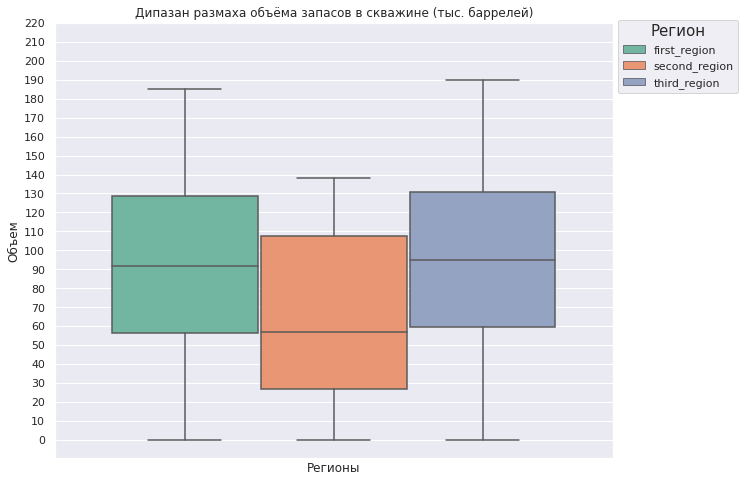

In [12]:
# Посмотрим на график размаха разные регионов по целевому признаку "product"

# В библиотеке pandas есть встроенная функция "melt", которая "переворачивает" (unpivots) датафрей
# из широкого формата (wide format) в длинный (long format) (позволяет сделать названия столбцов самим столбцом)
melt_region_data = pd.melt(region_data[['product', 'region']], id_vars=['region'], var_name=['product'], value_name="value")

# Отображаем на графике

sns.set(rc={'figure.figsize':(10,8)})
colors = sns.color_palette("Set2")
ax = sns.boxplot(x='product', y='value', hue='region', data=melt_region_data, palette = colors)
plt.title('Дипазан размаха объёма запасов в скважине (тыс. баррелей)')
plt.ylabel('Объем')
plt.xlabel('Регионы')
plt.yticks(ticks=np.arange(0,221,10))
plt.xticks([])
legend = plt.legend(title = "Регион", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Как мы можем заметить по графикам размаха распределение объёмов запасов в скважинах (тыс. баррелей) первого итретьего региона близки: медианы равны 91 и 95 тыс. соответсвенно, диапазон ящиков так же похожи, в третьем регионе идет небольшое смещение в положительную сторону, так же в этом регионе верхний "ус" уходит на 5 тыс. дальше. Во втором регионе медиана  и размах "усов" примерно в 1,5 раза меньше.

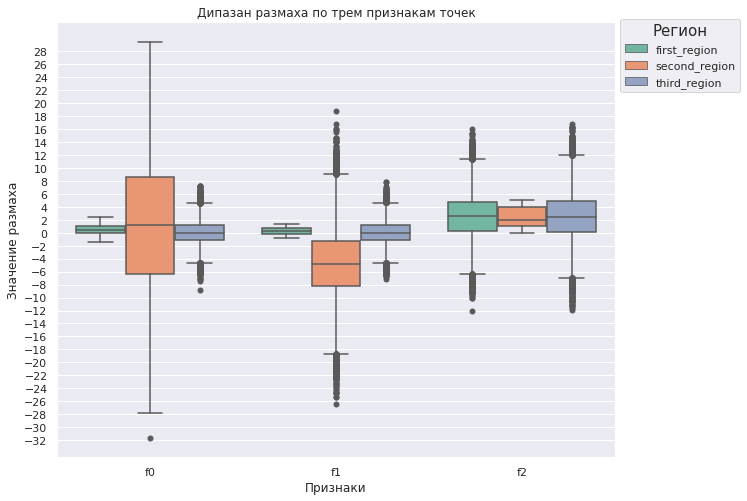

In [13]:
# Посмотрим на график размаха разные регионов по трем признакам точек

# "переварачиваем" датафрейм для признаков
melt_region_data = pd.melt(region_data[['f0', 'f1', 'f2', 'region']], id_vars=['region'], var_name=['f_value'],
                           value_name="value")

# Отображаем на графике

sns.set(rc={'figure.figsize':(10,8)})
colors = sns.color_palette("Set2")
ax = sns.boxplot(x='f_value', y='value', hue='region', data=melt_region_data, palette = colors,
                flierprops={"marker": "o"})
plt.title('Дипазан размаха по трем признакам точек')
plt.ylabel('Значение размаха')
plt.xlabel('Признаки')
plt.yticks(ticks=np.arange(-32,30,2))
legend = plt.legend(title = "Регион", title_fontsize = 15, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

Из-за различий масштаба данные трудно читаемы. В целом можем сказать, что у параметров f0 и f1 второго региона самые большие размахи. Параметр f2 хоть как-то сбалансирован между регионами. Мы видим большое количество выбросов у половины признаков. Но удалять мы их не будем, так как данные у нас заполнены полностью, пропуски отсутсвуют. В дальнейшем обучать модель будет по всем имеющимся данным. 

По проведенным исследованиям заметны дисбалансы значений f0, f1, f2, как между собой, так и между регионами. Возможно необходимо отмасштабировать данные, проверим это далее на одном из датафреймов. 

In [14]:
# Воспользуемся методом корреляции и хитмепом для наблюдения зависимостей

def corr_data(data):
# смотрим матрицу корреляции
    display(data.corr())

# Визуализируем
    plt.figure(figsize = (16, 8))
    sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
    plt.title('Матрица корреляции')
    plt.show()   

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


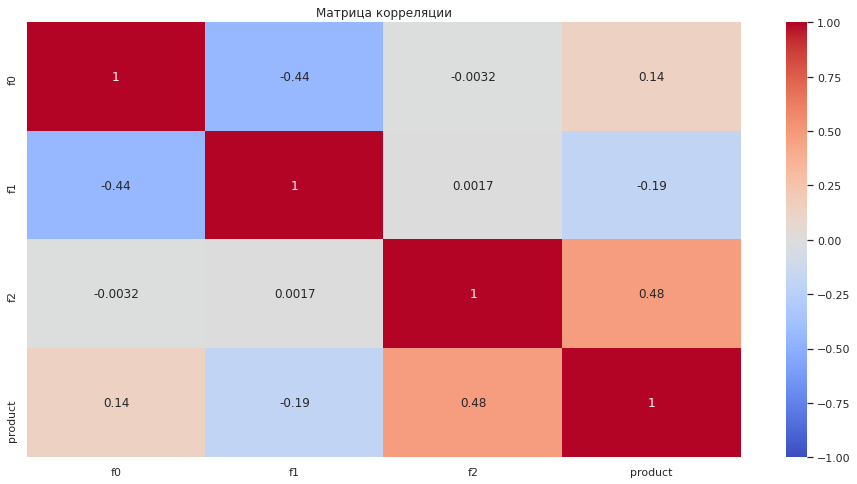

In [15]:
# Корреляция в первом регионе
corr_data(first_data)

По первому региону видим: среднуюю прямопропорциональную линейную положительную зависимость между значениями f2 и объемом запасов в скважине (0,48), незначитеную пололожительную зависимость между f0 и product (0,14) и отрицательную между f1 и product(-0,19), а так же среднюю отрицательную зависимость между параметрами f0 И f1.

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


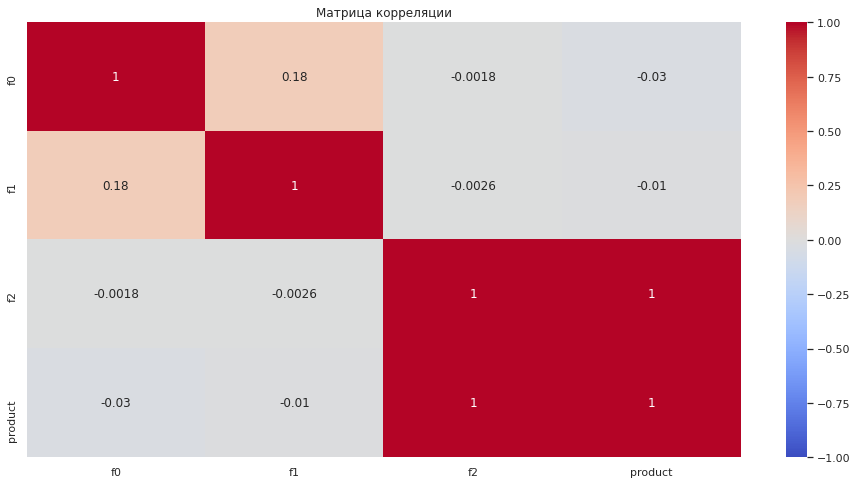

In [16]:
# Корреляция во втором регионе
corr_data(second_data)

По второму региону видим мультиколлинеарность для f2 и product, а для признаков f0 и f1 незначительную положительную зависимость. Полная коллинеарность приводит к неопределенности параметров в линейной регрессиионной модели независимо от методов оценки.

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


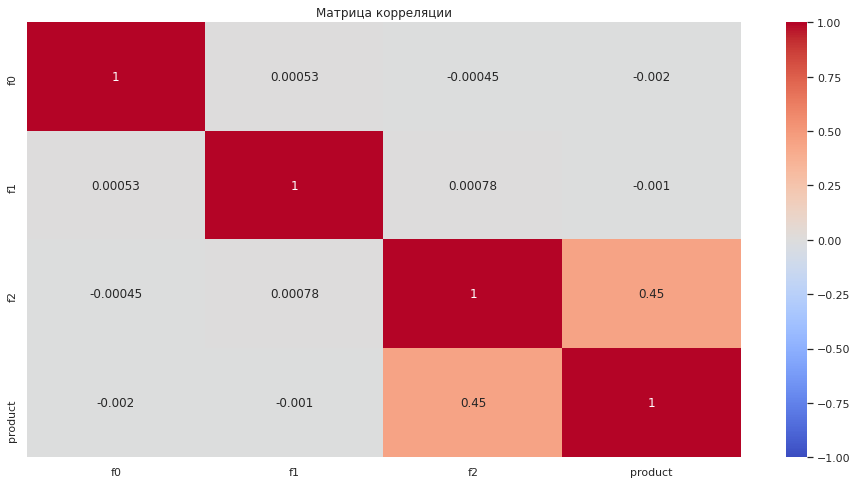

In [17]:
# Корреляция в третьем регионе
corr_data(third_data)

Между product и f2 средняя положительная зависимость (0,45).

In [ ]:
sns.pairplot(region_data, diag_kind='kde', hue='region', plot_kws={'alpha': 0.3})
plt.show()

Графики наглядно показывают нам сильные разбросы значений, преобладание одних параметров над другими.

## Обучение и проверка модели

*Проверим на примере первого датафрейма обучение модели (в виду проверки на необходимость масштабирования, гиперпараметры подбирать не будем, оставим в стандартном состоянии). Анализировать будем по значению MSE (средняя квадратичная ошибка); коэффициенту детерминации (метрика R2) (вычисляет долю средней квадратичной ошибки модели от MSE среднего, а затем вычитает эту величину из единицы.) и MAE (среднее абсолютное отклонение)*


Масштабируем с помощью:
- `Min-Max масштабирования`. Техника, при которой значения масштабируются таким образом, что становятся в диапазоне от 0 до 1. Сохраняет форму исходного распределения. Не снижает важность выбросов.
- `Стандартизации`. Изменение характеристик таким образом, чтобы среднее стало равно 0, а стандартное отклонение 1.

Масштабируем следующим образом: разделям выборку на обучающую и валидационную, затем настраиваем на обучающих данных, потом трансформируем (преобразуем) все выборки и обучающую и валидационную.

In [4]:
# Объявим переменные признака и цели

# Удалим из датафрейма столбец id, т.к. влияния на обучение модели он не даст из-за того, что это уникальный индификатор
check_features = first_data.drop(['id', 'product'], axis=1) #  признаки для обучающей модели
check_target = first_data['product'] # записываем цель (задача классификации)

display(check_features.head(2))

,f0,f1,f2
0,0.705745,-0.497823,1.22117
1,1.334711,-0.340164,4.36508


In [ ]:
# Посмотри на распределение целевого признака, что бы в дальнейшем понимать допустили ли мы ощибку и насколько она критична
sns.kdeplot(check_target)
plt.show()

In [5]:
# С помощью функции train_test_split разобьем датасет на обучающую и валидационную в соотношении 75:25.
# Размер выборки (test_size) = 0,25 (выражается в долях — от 0 до 1), на валидационную выборку отправляем 25% исходных данных

features_train, features_valid, target_train, target_valid = train_test_split(
    check_features, check_target, test_size=0.25, random_state=12345)

# Смотрим размер выборки 
print('Размер обучающей выборки:\n', features_train.shape, '\n', target_train.shape)
print('')
print('Размер валидационной  выборки:\n', features_valid.shape, '\n', target_valid.shape)

Размер обучающей выборки:
 (75000, 3) 
 (75000,)

Размер валидационной  выборки:
 (25000, 3) 
 (25000,)


Используем для построения модели **Линейную регрессия (Linear Regression)**

Линейная регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков.
Модель LinearRegression лежит в модуле sklearn.linear_model (от англ. «линейная модель») библиотеки sklearn. Импортируем его:
`from sklearn.linear_model import LinearRegression`

In [6]:
# Создадим таблицу результатов 

result_table = pd.DataFrame(index = ['raw_data', 'MinMaxScaler', 'StandardScaler'],
                columns = ['mean_squared_error_train', 'mean_squared_error_test',
                           'r2_score_train', 'r2_score_test',
                           'mean_absolute_error_train', 'mean_absolute_error_test'])

result_table

,mean_squared_error_train,mean_squared_error_test,r2_score_train,r2_score_test,mean_absolute_error_train,mean_absolute_error_test
raw_data,NaN,NaN,NaN,NaN,NaN,NaN
MinMaxScaler,NaN,NaN,NaN,NaN,NaN,NaN
StandardScaler,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Обучим

# создадим функцию для обучения модели
def model_train(x_train, y_train, x_valid, y_valid, method, metric_name, metric):
    model = LinearRegression() # инициализируем модель LinearRegression
    model.fit(x_train, y_train) # обучим модель на тренировочной выборке
    predicted_train = model.predict(x_train) # получим предсказания модели на обучающей выборке
    predicted_valid = model.predict(x_valid) # получим предсказания модели на валидационной выборке
    
    print(metric_name, 'модели линейной регрессии на обучающей выборке:', 
          metric(y_train, predicted_train)) # посчитаем значение метрики на обучающей выборке
    print(metric_name, 'модели линейной регрессии на валидационной выборке:', 
          metric(y_valid, predicted_valid)) # посчитаем значение метрики на валидационной выборке
    
    result_table.loc[method, metric_name+'_train'] = round(metric(y_train, predicted_train), 3)
    result_table.loc[method, metric_name+'_test'] = round(metric(y_valid, predicted_valid), 3)
    

In [8]:
# Сделаем цикл для подбора наименования и самого метода определения ошибки
metrics_name = ['mean_squared_error', 'r2_score', 'mean_absolute_error']
metrics = [mean_squared_error, r2_score, mean_absolute_error]
for i in range(len(metrics_name)):
    model_train(features_train, target_train, features_valid, target_valid, 'raw_data', metrics_name[i], metrics[i])

result_table

mean_squared_error модели линейной регрессии на обучающей выборке: 1423.5523113396391
mean_squared_error модели линейной регрессии на валидационной выборке: 1412.2129364399243
r2_score модели линейной регрессии на обучающей выборке: 0.27423906493940775
r2_score модели линейной регрессии на валидационной выборке: 0.27994321524487786
mean_absolute_error модели линейной регрессии на обучающей выборке: 31.079961075786297
mean_absolute_error модели линейной регрессии на валидационной выборке: 30.919600777151313


,mean_squared_error_train,mean_squared_error_test,r2_score_train,r2_score_test,mean_absolute_error_train,mean_absolute_error_test
raw_data,1423.552,1412.213,0.274,0.28,31.08,30.92
MinMaxScaler,NaN,NaN,NaN,NaN,NaN,NaN
StandardScaler,NaN,NaN,NaN,NaN,NaN,NaN


Ошибка равная 37, это почти одна пятая от распределения целевого признака. Неприятно

In [9]:
# Применим MinMaxScaler

mms = MinMaxScaler() # инициализируем модель масштабирования
mms.fit(features_train) # обучим модель на тренировочной выборке
display(mms.data_min_) # смотрим минимальные значения для обучающих параметров
features_train_mms = pd.DataFrame(mms.transform(features_train), columns=features_train.columns,
                                  index=features_train.index) # преобразуем обучающую выборку
features_valid_mms = pd.DataFrame(mms.transform(features_valid), columns=features_valid.columns,
                                  index=features_valid.index) # преобразуем валидационную выборку
display(features_train_mms.describe()) # посмотрим на получившиеся распределения на трейне, находятся ли в диапазоне от 0 до 1

array([ -1.40860531,  -0.8482185 , -10.13834135])

,f0,f1,f2
count,75000.000000,75000.000000,75000.000000
mean,0.505457,0.501044,0.483674
std,0.231196,0.230021,0.124308
min,0.000000,0.000000,0.000000
25%,0.353434,0.295744,0.399150
50%,0.505891,0.500874,0.484207
75%,0.657379,0.706417,0.568572
max,1.000000,1.000000,1.000000


In [10]:
for i in range(len(metrics_name)):
    model_train(features_train_mms, target_train, features_valid_mms, target_valid, 'MinMaxScaler', metrics_name[i], metrics[i])

result_table

mean_squared_error модели линейной регрессии на обучающей выборке: 1423.5523113396391
mean_squared_error модели линейной регрессии на валидационной выборке: 1412.2129364399243
r2_score модели линейной регрессии на обучающей выборке: 0.27423906493940775
r2_score модели линейной регрессии на валидационной выборке: 0.27994321524487786
mean_absolute_error модели линейной регрессии на обучающей выборке: 31.079961075786297
mean_absolute_error модели линейной регрессии на валидационной выборке: 30.919600777151313


,mean_squared_error_train,mean_squared_error_test,r2_score_train,r2_score_test,mean_absolute_error_train,mean_absolute_error_test
raw_data,1423.552,1412.213,0.274,0.28,31.08,30.92
MinMaxScaler,1423.552,1412.213,0.274,0.28,31.08,30.92
StandardScaler,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Масштабируем признаки с помощью стандартизация данных.

# Чтобы не появлялось предупреждение SettingWithCopy добавим в код строчку:
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:,.2f}'.format) #уберем "е" из отображения формата данных

# Создадим объект StandardScaler (структура для стандартизации данных)  и настроим его на обучающих данных. 
# Настройка — это вычисление среднего и дисперсии
scaler = StandardScaler()
scaler.fit(features_train)

display(scaler.mean_) #посмотрим на средниче значения

# Преобразуем обучающую и валидационную выборки функцией transform().
features_train_ss = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns,
                                  index=features_train.index)
features_valid_ss = pd.DataFrame(scaler.transform(features_valid), columns=features_valid.columns,
                                  index=features_valid.index)
display(features_train_ss.describe()) # посмотрим на получившиеся распределения, равняется ли средняя 0

array([0.49744058, 0.25006378, 2.50591697])

,f0,f1,f2
count,"75,000.00","75,000.00","75,000.00"
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.19,-2.18,-3.89
25%,-0.66,-0.89,-0.68
50%,0.00,-0.00,0.00
75%,0.66,0.89,0.68
max,2.14,2.17,4.15


In [12]:
for i in range(len(metrics_name)):
    model_train(features_train_ss, target_train, features_valid_ss, target_valid, 'StandardScaler', metrics_name[i], metrics[i])

result_table

mean_squared_error модели линейной регрессии на обучающей выборке: 1423.5523113396391
mean_squared_error модели линейной регрессии на валидационной выборке: 1412.2129364399243
r2_score модели линейной регрессии на обучающей выборке: 0.27423906493940775
r2_score модели линейной регрессии на валидационной выборке: 0.27994321524487786
mean_absolute_error модели линейной регрессии на обучающей выборке: 31.079961075786297
mean_absolute_error модели линейной регрессии на валидационной выборке: 30.919600777151313


,mean_squared_error_train,mean_squared_error_test,r2_score_train,r2_score_test,mean_absolute_error_train,mean_absolute_error_test
raw_data,"1,423.55","1,412.21",0.27,0.28,31.08,30.92
MinMaxScaler,"1,423.55","1,412.21",0.27,0.28,31.08,30.92
StandardScaler,"1,423.55","1,412.21",0.27,0.28,31.08,30.92


После проверки результатов метрик оценки качества модели на стандартном датафрейме и масштабированном, можем заметить, что качество модели не изменилось. Хотя линейные модели весьма зависимы от масштаба данных.

Для масштабирования линейных и логистических регрессий лучше подходит стандартизация данных. Так как на проверочном датафрейме качество не менялось, то дальнейшие исследования будем использовать с отмасштабироваными стандартизацией данными.

<h2>Обучение модели Линейной регрессии<a class="tocSkip"></h2>  

In [13]:
# создадим функция для обучение модели для каждого региона

def model_train(df):
    
# Объявим переменные регрессоры и предиктор
    features = df.drop(["product","id"], axis=1)
    target = df["product"]
    
# Разобьем датасет на обучающую и валидационную выборки в соотношении 75:25    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)

# Масштабируем признаки
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)

# Обучим модель    
    model = LinearRegression(normalize=False).fit(features_train, target_train)

# Получим предсказания модели на валидационной выборке 
    pred = model.predict(features_valid)

# Рассчитаем метрики качества модели    
    RMSE = np.sqrt(mean_squared_error(pred, target_valid))
    R2 = model.score(features_valid, target_valid)
    average_stock = pred.mean()
    
    print('RMSE: {0:.4f}'.format(RMSE))
    print('')
    print('R2: {0:.4f}'.format(R2))
    print('')
    print('Cредний запас предсказанного сырья: {0:.4f}'.format(average_stock))
    print('')

# Вовзращаем необходимые парамаетры    
    return (pred, target_valid.reset_index(drop=True), RMSE, R2)

In [14]:
regions_name = 1
for region in [first_data, second_data, third_data]:
    print(f'{regions_name} регион:')
    print('')
    model_train(region)
    print('**'*30, '\n\n')
    regions_name += 1

1 регион:

RMSE: 37.5794

R2: 0.2799

Cредний запас предсказанного сырья: 92.5926

************************************************************ 


2 регион:

RMSE: 0.8931

R2: 0.9996

Cредний запас предсказанного сырья: 68.7285

************************************************************ 


3 регион:

RMSE: 40.0297

R2: 0.2052

Cредний запас предсказанного сырья: 94.9650

************************************************************ 




In [15]:
# Сохраним получившиеся значения предсказаний и метрик качества
first_reg_pred, first_reg_val, first_reg_rmse, first_reg_r2 = model_train(first_data)
second_reg_pred, second_reg_val, second_reg_rmse, second_reg_r2 = model_train(second_data)
third_reg_pred, third_reg_val, third_reg_rmse, third_reg_r2 = model_train(third_data)

RMSE: 37.5794

R2: 0.2799

Cредний запас предсказанного сырья: 92.5926

RMSE: 0.8931

R2: 0.9996

Cредний запас предсказанного сырья: 68.7285

RMSE: 40.0297

R2: 0.2052

Cредний запас предсказанного сырья: 94.9650



И так, мы получили следующие результаты:
- Первый регион: RMSE: 37.5794, R2: 0.2799, Cредний запас предсказанного сырья: 92.5926;
- Второй регион: RMSE: 0.8931, R2: 0.9996, Cредний запас предсказанного сырья: 68.7285;
- Третий регион: RMSE: 40.0297, R2: 0.2052, Cредний запас предсказанного сырья: 94.9650.

Видим картину, которая хорошо согласуется с распределением, первый и второй наборы данных имеют довольно схожие результаты, RMSE около 40, а средний запас предсказанного сырья находится в диапазоне 92-95 тыс. баррелей. Во втором регионе хороший низкий показатель RMSE около 0,89 и почти идеальный, стремящийся к единице, коэффициент детерминации, но при этом низкий средний запас на уровне 68 тыс. баррелей, в отличие от других регионов.

## Подготовка к расчёту прибыли

***Продублируем еще раз условия задачи:***
- Для обучения модели подходит только линейная регрессия.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [16]:
# зададим переменные
budget = 10000000000 # бюджет
all_points = 500 # кол-во точек
best_points = 200 # лучшие точки для разработки
income_per_point = 450000 # доход с каждой единицы продукта
thres_risk_max = 2.5/100 # максимальная вероятность убытка

In [17]:
# Рассчитаем объем запасов, достаточный для разработки новой скважины без потерь

volume_reserves =  budget/income_per_point/best_points
print(f' Объем запасов, достаточный для разработки новой скважины без потерь: {volume_reserves:.2f} тыс. баррелей')

 Объем запасов, достаточный для разработки новой скважины без потерь: 111.11 тыс. баррелей


Для первого региона мы предсказали самое высокое значение среднего запаса сырья: 92.5926 тыс. барралей, что меньше, чем полученное значение безубыточного функционирования скважины (111.11 тыс. барралей)

In [18]:
# Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

# На вход функция получает предсказания и целевой признак,
# а на выходе выдает выручку (доходность минус выделенный бюджет на разработку скважин)
def income_calculation(predictions, target):
    target = pd.Series(target)
    predictions = pd.Series(predictions)
    top_predictions = predictions.sort_values(ascending=False) # отсортируем по убыванию предсказания модели
    top_borehole = target[top_predictions.index][:200] # выделим лучшие предсказанные 200 скважин региона
    revenue = top_borehole.sum() * income_per_point # выручка: объем запасов с 200 скважин умноженное на их доход с ед. продукта
    return revenue - budget

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [19]:
# создадим функцию по подсчету 95% интервала и риска убытка.

def profit_distribution(predictions, target): 
    state = np.random.RandomState(12345) # указываем random_state для воспроизводимости, 
                                    # при каждом новом вызове его состояние будет меняться на случайное
    values = []
    target = pd.Series(target)
    predictions = pd.Series(predictions)
    for i in range(1000): # извлекаем из выборки 1 случайный элемент
    
# при создании подвыборок должны обеспечиваться выбор элементов с возвращением,
# один и тот же элемент может попадать в подвыборку несколько раз. Для этого укажите аргумент replace=True в функции sample()
        target_sample = target.sample(n=all_points, replace=True, random_state=state)
# добавляем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
        values.append(income_calculation(predictions[target_sample.index], target_sample))
    
    values = pd.Series(values) 
# Для построения 95%-го доверительного интервала нужно выкинуть 5% экстремальных значений,
# то есть 2.5% самых больших и 2.5% самых маленьких.       
    lower = values.quantile(0.025) # Точка, на которой заканчивается 2.5% самых маленьких значений, — 0.025-квантиль.
    higher =values.quantile(0.975) # Точка, с которой начинается 2.5% самых больших значений, — 0.975-квантиль.
    mean_revenue = values.mean() # средняя прибыль
    risk = st.percentileofscore(values, 0) # метод вычисляет процентный ранг значения относительно списка значений.
    
    return ((lower, higher), mean_revenue, risk, values)

In [20]:
# Выведем на экран наши результаты

regions_name = 1
for predictions, target in zip([first_reg_pred, second_reg_pred, third_reg_pred], 
                         [first_reg_val, second_reg_val, third_reg_val]):
    interval, mean_revenue, risk, values = profit_distribution(predictions, target)
    print(f'{regions_name} регион:')
    print('')
    print(f"Средняя прибыль: {mean_revenue}")
    print(f"95%-й доверительный интервал: {interval}")
    print(f"Риск убытков: {risk}")
    print('**'*30, '\n\n')
    regions_name += 1

1 регион:

Средняя прибыль: 425938526.91059244
95%-й доверительный интервал: (-102090094.83793654, 947976353.3583689)
Риск убытков: 6.0
************************************************************ 


2 регион:

Средняя прибыль: 515222773.4432899
95%-й доверительный интервал: (68873225.37050176, 931547591.2570494)
Риск убытков: 1.0
************************************************************ 


3 регион:

Средняя прибыль: 435008362.7827556
95%-й доверительный интервал: (-128880547.32978901, 969706954.1802661)
Риск убытков: 6.4
************************************************************ 




+------------------------+--------------------+
|       Показатель       |      Значение      |
+------------------------+--------------------+
|    Средняя выручка     |     391.7 млн      |
|          Риск          |        7.6%        |
| Доверительный интервал | -154.5 : 974.7 млн |
+------------------------+--------------------+


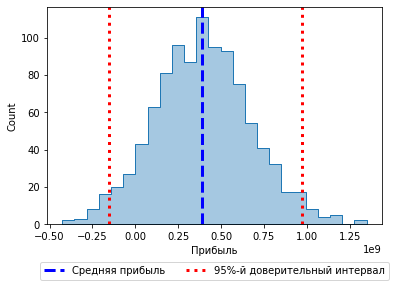

In [25]:
# !pip3 install prettytable
from prettytable import PrettyTable
import seaborn as sns
from scipy import stats as st

BUDGET = 10000000000
BARREL_COST = 450
BARRELS_IN_UNIT = 1000
UNIT_COST = BARREL_COST * BARRELS_IN_UNIT
TOTAL_POINTS = 500
POINTS = 200

def revenue_2(target, predictions, points, budget, unit_cost):
    predicted_sorted = predictions.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:points]
    return selected.sum() * unit_cost - budget

def bootstrap_2(target, probabilities):
    state = np.random.RandomState(888)
    values=[]
    for i in range(1000):
        target_subsample = target.sample(replace=True,\
            random_state=state, n=TOTAL_POINTS)

        probs_subsample = probabilities[target_subsample.index]
        values.append(revenue_2(target_subsample, probs_subsample, POINTS, BUDGET, UNIT_COST))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = st.percentileofscore(values, 0)

     # Отображение таблицы
    table = PrettyTable()
    table.field_names = ['Показатель', 'Значение']
    table.add_row(['Средняя выручка', f'{mean/1e6:.1f} млн'])
    table.add_row(['Риск', f'{risk:.2}%'])
    table.add_row(['Доверительный интервал', f'{lower/1e6:.1f} : {upper/1e6:.1f} млн'])
    print(table)

    sns.histplot(values, alpha=0.4,  element="step")
    plt.xlabel('Прибыль')
    plt.axvline(x=mean, color='b', ls='--', lw=3, label='Средняя прибыль')
    plt.axvline(x=lower, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()

bootstrap_2(first_reg_val, pd.Series(first_reg_pred))

Для решения задачи добывающей компании «ГлавРосГосНефть», где бурить новую скважину:
- мы проанализировали собранные характеристики для скважин в трех избранных регионах: качество нефти и объём её запасы;
- Построили модель Линейной регрессии с проверкой методов масштабирования для предсказания объёма запасов в новых скважинах;
- Определили скважины с самыми высокими оценками значений, в качестве метрик качества рассматривали RMSE (квадратный корень из средней квадратичной ошибки) и Коэффициент детерминации (метрика R2), а также посмотрели средний запас предсказанного сырья;
- Выявили, что во втором регионе хороший низкий показатель RMSE около 0,89 и почти идеальный, стремящийся к единице, коэффициент детерминации, но при этом низкий средний запас на уровне 68 тыс. баррелей, в отличие от других регионов.
- Выяснили, что запас сырья в скважинах меньше, чем точка безубыточности.
- Воспользовавшись процедурой бутстрэпа, мы нашли 95% доверительный интервал для среднего объема нефти в скважинах. Таким образом определили регион с максимальной суммарной прибылью отобранных скважин. ***Наиболее перспективным для разработки представляется второй регион***. Мы имеем наиболее ценный доверительный интервал с хорошей средней прибылью около 515 млн (также среднее прогнозируемое значение и коэффициент детерминации близки к единице и низкий RMSE), при этом риск убытков составляет 1%. К тому же после оценки рисков мы можем оставить лишь только данный регионы, так как вероятность убытков меньше заданных 2.5%. Риски первого и третьего регионов 6% и 6,4% соответсвенно.
